In [1]:
import argparse
import os, sys
import json
import numpy as np

from config import config
from model import siMLPe as Model
from datasets.amass import AMASSDataset
from utils.logger import get_logger, print_and_log_info
from utils.pyt_utils import link_file, ensure_dir
from utils.angle_to_joint import ang2joint
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


2024-02-01 07:54:36.635644: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-01 07:54:37.002304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
skeleton_info = np.load(
                os.path.join('../..', 'body_models', 'smpl_skeleton.npz')
                )
p3d0 = torch.from_numpy(skeleton_info['p3d0']).float()
parents = skeleton_info['parents']

In [9]:
from scipy.spatial.transform import Rotation as R
amass_info = np.load('../../data/amass/ACCAD/Female1General_c3d/A1 - Stand_poses.npz')
amass_motion_poses = amass_info['poses'] # 156 joints(all joints of SMPL)
N = len(amass_motion_poses)
# if N < self.amass_motion_target_length + self.amass_motion_input_length:
#     continue

frame_rate = amass_info['mocap_framerate']
sample_rate = int(frame_rate // 25)
sampled_index = np.arange(0, N, sample_rate)
amass_motion_poses = amass_motion_poses[sampled_index]

T = amass_motion_poses.shape[0]
amass_motion_poses = R.from_rotvec(amass_motion_poses.reshape(-1, 3)).as_rotvec()
amass_motion_poses = amass_motion_poses.reshape(T, 52, 3)
amass_motion_poses[:, 0] = 0

p3d0 = np.load('../../body_models/smpl_skeleton.npz')['p3d0']
p3d0 = torch.from_numpy(skeleton_info['p3d0']).float()
parents = np.load('../../body_models/smpl_skeleton.npz')['parents']
parent = {}
for i in range(len(parents)):
    parent[i] = parents[i]
p3d0_tmp = p3d0.repeat([amass_motion_poses.shape[0], 1, 1])
amass_motion_poses = ang2joint(p3d0_tmp, torch.tensor(amass_motion_poses).float(), parent).reshape(-1, 52, 3)[:, :22]

# all_amass_motion_poses.append(amass_motion_poses)

In [10]:
pose = amass_motion_poses[0]
# for i in range(1, 22):
#     pose[i] = pose[parent[i]] + pose[i]

In [11]:
Ll_x = []
Ll_y = []
Ll_z = []
i = 10
while i >= 0:
    print(i)
    Ll_x.append(pose[i, 0])
    Ll_y.append(-pose[i, 2])
    Ll_z.append(pose[i, 1])
    i = parents[i]

10
7
4
1
0


In [12]:
Rl_x = []
Rl_y = []
Rl_z = []
i = 11
while i >= 0:
    print(i)
    Rl_x.append(pose[i, 0])
    Rl_y.append(-pose[i, 2])
    Rl_z.append(pose[i, 1])
    i = parents[i]

11
8
5
2
0


In [13]:
T_x = []
T_y = []
T_z = []
i = 15
while i >= 0:
    print(i)
    T_x.append(pose[i, 0])
    T_y.append(-pose[i, 2])
    T_z.append(pose[i, 1])
    i = parents[i]

15
12
9
6
3
0


In [14]:
La_x = []
La_y = []
La_z = []
i = 20
while i >= 0:
    print(i)
    La_x.append(pose[i, 0])
    La_y.append(-pose[i, 2])
    La_z.append(pose[i, 1])
    i = parents[i]

20
18
16
13
9
6
3
0


In [15]:
Ra_x = []
Ra_y = []
Ra_z = []
i = 21
while i >= 0:
    print(i)
    Ra_x.append(pose[i, 0])
    Ra_y.append(-pose[i, 2])
    Ra_z.append(pose[i, 1])
    i = parents[i]

21
19
17
14
9
6
3
0


In [16]:
pose

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0726, -0.0904, -0.0050],
        [-0.0710, -0.0899, -0.0043],
        [-0.0029,  0.1082, -0.0280],
        [ 0.0884, -0.4784, -0.0452],
        [-0.0927, -0.4849, -0.0295],
        [ 0.0040,  0.2468, -0.0162],
        [ 0.0723, -0.8882, -0.0778],
        [-0.0546, -0.8900, -0.0844],
        [ 0.0040,  0.2996,  0.0150],
        [ 0.1004, -0.9411,  0.0466],
        [-0.1003, -0.9455,  0.0334],
        [-0.0083,  0.5228, -0.0101],
        [ 0.0798,  0.4303, -0.0103],
        [-0.0838,  0.4184, -0.0201],
        [-0.0054,  0.5940,  0.0476],
        [ 0.1788,  0.4288, -0.0172],
        [-0.1856,  0.4057, -0.0218],
        [ 0.2170,  0.1633, -0.0460],
        [-0.2043,  0.1466, -0.0353],
        [ 0.2669, -0.0657,  0.0629],
        [-0.2265, -0.0859,  0.0820]])

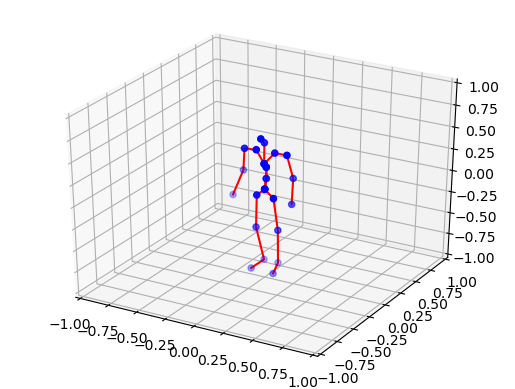

In [13]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.figure()  # 得到畫面
ax1 = plt.axes(projection='3d')
ax1.set_xlim(-1, 1)  # X軸，橫向向右方向
ax1.set_ylim(-1, 1)  # Y軸,左向與X,Z軸互為垂直
ax1.set_zlim(-1, 1)  # 豎向為Z軸
# color1 = ['r', 'g', 'b', 'k', 'm']
marker1 = ['o', 'v', '1', 's', 'H']
ax1.scatter(Ll_x, Ll_y, Ll_z, c='b', marker='o', linewidths=1)  # 用散點函數畫點
ax1.plot(Ll_x, Ll_y, Ll_z, c='r')
ax1.scatter(Rl_x, Rl_y, Rl_z, c='b', marker='o', linewidths=1)  # 用散點函數畫點
ax1.plot(Rl_x, Rl_y, Rl_z, c='r')
ax1.scatter(La_x, La_y, La_z, c='b', marker='o', linewidths=1)  # 用散點函數畫點
ax1.plot(La_x, La_y, La_z, c='r')
ax1.scatter(Ra_x, Ra_y, Ra_z, c='b', marker='o', linewidths=1)  # 用散點函數畫點
ax1.plot(Ra_x, Ra_y, Ra_z, c='r')
ax1.scatter(T_x, T_y, T_z, c='b', marker='o', linewidths=1)  # 用散點函數畫點
ax1.plot(T_x, T_y, T_z, c='r')
plt.show()